# Classes, methods, init

## What is class and method?
```py
>>> from sklearn import tree # Import a class
>>> X = [[0, 0], [1, 1]]
>>> Y = [0, 1]
>>> clf = tree.DecisionTreeClassifier(criterion='gini') # instantiate a class
# clf is an instance of a class
>>> clf = clf.fit(X, Y) # call class method
```

## Creating our own class.
```py
    class Person:
    def __init__(self, name: str, age: int):
        self.name = name
        self.age = age
```

## Public, private, dunder methods
- Python doesn't have private methods by default, but we use `_` as convection (`_private_method()`).
- Dunder (double underscore) methods in Python allow to interact with the built-in functions and operators of the language.
- E.g. `__repr__, __str__, __eq__, __add__, __mul__, __neg__, __sub__`

FYI: Check out data classes if you want more something like data structure, instead of actor.
```py
from dataclasses import dataclass

@dataclass
class Person:
    name: str
    age: int

p1 = Person("Alice", 30)
p2 = Person("Alice", 30)
print(p1 == p2)  # True
```

In [1]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

In [2]:
val = Value(5)
assert val.data == 5
print(val)

Value(data=5)


# Implementing arithmetic operations

In [3]:
Value(2) + Value(3)

TypeError: unsupported operand type(s) for +: 'Value' and 'Value'

In [ ]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data)

        return out

    def __mul__(self, other):
        out = Value(self.data * other.data)

        return out

In [ ]:
Value(2) + Value(3)


## Adding subtraction

Value(2) - Value(3)

In [4]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data = data

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data + other.data)

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data)

        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

In [5]:
Value(2) - Value(3)

Value(data=-1)

# Linking with children

In [6]:
A = Value(1)
B = Value(2)
C = Value(3)

D = A * B + C

In [7]:
D._prev

AttributeError: 'Value' object has no attribute '_prev'

In [8]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data):
        self.data
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __repr__(self):
        return f"Value(data={self.data}, op={self._op})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data)
        out = Value(self.data + other.data, (self, other), '+')

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data)
        out = Value(self.data * other.data, (self, other), '*')

        return out

In [9]:

A = Value(1)
B = Value(2)
C = Value(3)

D = A * B + C

In [10]:
D._prev

{Value(data=2, op=*), Value(data=3, op=)}

In [11]:
list(D._prev)[1]._prev


{Value(data=1, op=), Value(data=2, op=)}

# Mapping the graph

We can use recursion. Lends well to mathematical induction. Example: Fibonacci sequrence.

In [12]:
def trace(root_node):
    nodes, edges = set(), set()
    # 1. add node to set of `nodes` if not yet there
    # 2. go through all immediate children of node
    # 3. add edges to `edges` set
    # 4. recursively apply function to the children
    return notes, edges

In [13]:
A = Value(1)
B = Value(2)
C = Value(3)

D = A * B + C

In [14]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

In [15]:
nodes, edges = trace(D)

In [16]:
print(nodes)

{Value(data=2, op=), Value(data=2, op=*), Value(data=3, op=), Value(data=1, op=), Value(data=5, op=+)}


In [17]:
for edge in edges:
    print(edge)

(Value(data=3, op=), Value(data=5, op=+))
(Value(data=2, op=*), Value(data=5, op=+))
(Value(data=2, op=), Value(data=2, op=*))
(Value(data=1, op=), Value(data=2, op=*))


In [25]:
# !pip install graphviz
# + install in your os as well, like `brew install graphviz` or `sudo apt-get install graphviz`

In [26]:
from IPython.display import display

In [37]:
from graphviz import Digraph
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f}" % (n.data,), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


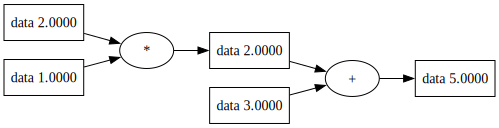

In [38]:
dot = draw_dot(D)
display(dot)

# Implementing autograd

- We will use lambda functions.
- They are inline functions, not available in global scope, used for simple operations and plug-and-play approach.

In [32]:
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __neg__(self): # -self
        return self * -1

    def __sub__(self, other): # self - other
        return self + (-other)

    def backward(self):

        # topological order all of the children in the graph
        # a topological sort is a graph traversal in which each node v is visited
        # only after all its dependencies are visited. 
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()    

In [42]:
from graphviz import Digraph
def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


In [39]:
A = Value(1)
B = Value(2)
C = Value(3)

D = A * B + C

In [40]:
D.backward()

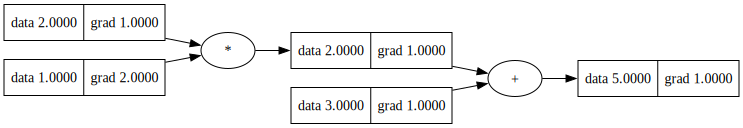

In [43]:
draw_dot(D)